In [ ]:
#|default_ex ricci

import jax
import jax.numpy as jnp
# diffusion curvature stuffs
from diffusion_curvature.diffusion_laziness import entropy_of_diffusion
import pygsp
import jax
import jax.numpy as jnp
from fastcore.all import *
import skdim
import scipy
from inspect import getfullargspec
from typing import Callable, Literal, get_args, get_origin
import graphtools
from tqdm.auto import trange, tqdm

from jax.experimental import sparse

from diffusion_curvature.graphs import diff_aff, diff_op, diffusion_matrix_from_affinities
from diffusion_curvature.heat_diffusion import heat_diffusion_on_signal, kronecker_delta, jax_power_matrix
from diffusion_curvature.diffusion_laziness import wasserstein_spread_of_diffusion, entropy_of_diffusion
from diffusion_curvature.distances import phate_distances_differentiable
from diffusion_curvature.comparison_space import EuclideanComparisonSpace, fit_comparison_space_model, euclidean_comparison_graph, construct_ndgrid_from_shape, diffusion_coordinates, load_average_entropies
from diffusion_curvature.clustering import enhanced_spectral_clustering
from diffusion_curvature.normalizing_flows import neural_flattener
from diffusion_curvature.vne import optimal_t_via_vne
from diffusion_curvature.utils import random_jnparray
import diffusion_curvature

import torch

# import deepdish
import h5py


# Diffusion Ricci Curvature

In [ ]:

def diffusion_curvature_of_affinity_matrix(A, t=25):
    P = A / A.sum(axis=1, keepdims=True)
    Pt = jax_power_matrix(P,t)
    # ks = entropy_of_diffusion(Pt)  
    entropy_elementwise = jax.scipy.special.entr(Pt)
    ks = jnp.sum(entropy_elementwise, axis=-1)
    return ks

def dcs_summed_over_edges(A, t, i, j):
    ks = diffusion_curvature_of_affinity_matrix(A, t=t)
    # ks_sums = ks[:,None] + ks[None,:]
    # return ks_sums[i,j]
    return ks[i]

def edgewise_diffusion_curvature(G, t):
    A = jnp.array(
        G.W.todense(),
        dtype=jnp.float32,
    )  # adjacency matrix
    
    # compute diffusion curvature
    ks_sums = jax.grad(dcs_summed_over_edges)(A, t=t)

    # differentiate ks_sums with respect to A
    R = jax.grad(ks_sums,A)

    def f(i, j):
        return ks[i] + ks[j]

    R = jax.jit(jax.vmap(jax.grad(f)))(jnp.arange(A.shape[0]), jnp.arange(A.shape[1]))

    return R

In [ ]:
from diffusion_curvature.datasets import torus
X, ks = torus(100)
G = graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()

In [ ]:
A = jnp.array(
        G.W.todense(),
        dtype=jnp.float32,
    )

In [ ]:
jax.grad(dcs_summed_over_edges)(A,2,4,7)[4,7]

Array(nan, dtype=float32)

In [ ]:
def DC_of_idx(A,i,t):
    P = (A / A.sum(axis=1, keepdims=True))
    Pt = jax_power_matrix(P,t)
    entropy_elementwise = jax.scipy.special.entr(Pt)
    entropy_of_rows = jnp.sum(entropy_elementwise, axis=-1)
    return entropy_of_rows[i]

In [ ]:
def differential_dc_of_edge(A,i,j,t):
    return jax.grad(DC_of_idx)(A,i,t)[i][j]+jax.grad(DC_of_idx)(A,j,t)[i][j]

In [ ]:
from tqdm.auto import trange
def differential_dc(A,t, eps=1e-8):
    # return a matrix of the edge wise diffusion curvatures for all edges
    # (i,j) is the edge from i to j
    R = jnp.zeros(A.shape)
    edges_used = jnp.zeros(A.shape)
    for i in trange(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i,j] > eps:
                R = R.at[i,j].set(differential_dc_of_edge(A,i,j,t))
                edges_used = edges_used.at[i,j].set(1)
    return R, edges_used

## 100 Point Torus

In [ ]:
R = differential_dc(A,25)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
scalar_ks = jnp.sum(R[0], axis=-1)

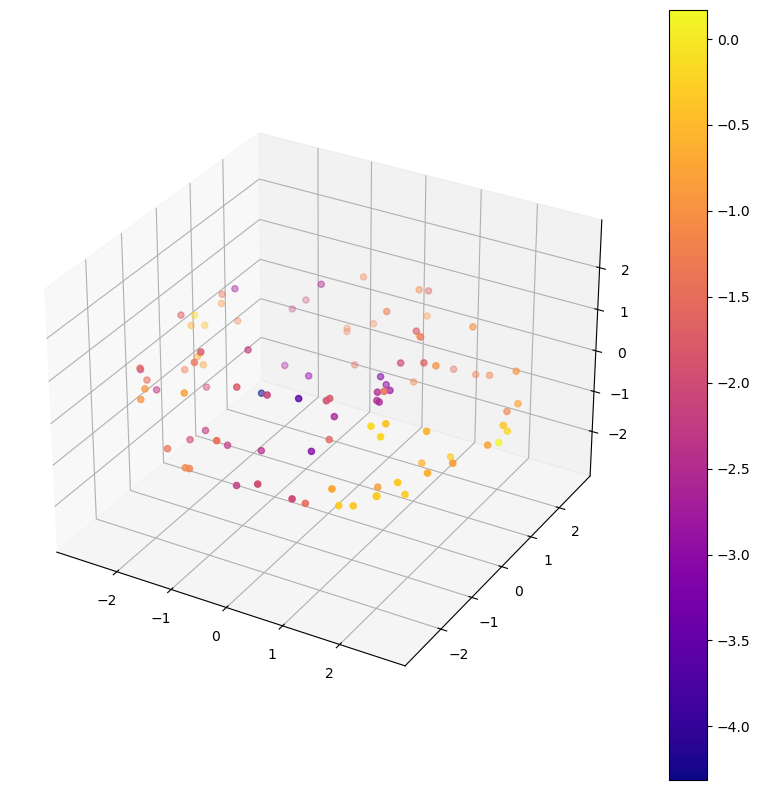

In [ ]:
from diffusion_curvature.utils import plot_3d
plot_3d(X,scalar_ks,colorbar=True)

## With 300 Point torus

In [ ]:
from diffusion_curvature.datasets import torus
X, ks = torus(300)
G = graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()

In [ ]:
A = jnp.array(
        G.W.todense(),
        dtype=jnp.float32,
    )

In [ ]:
R = differential_dc(A,25)

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
scalar_ks = jnp.sum(R[0], axis=-1)

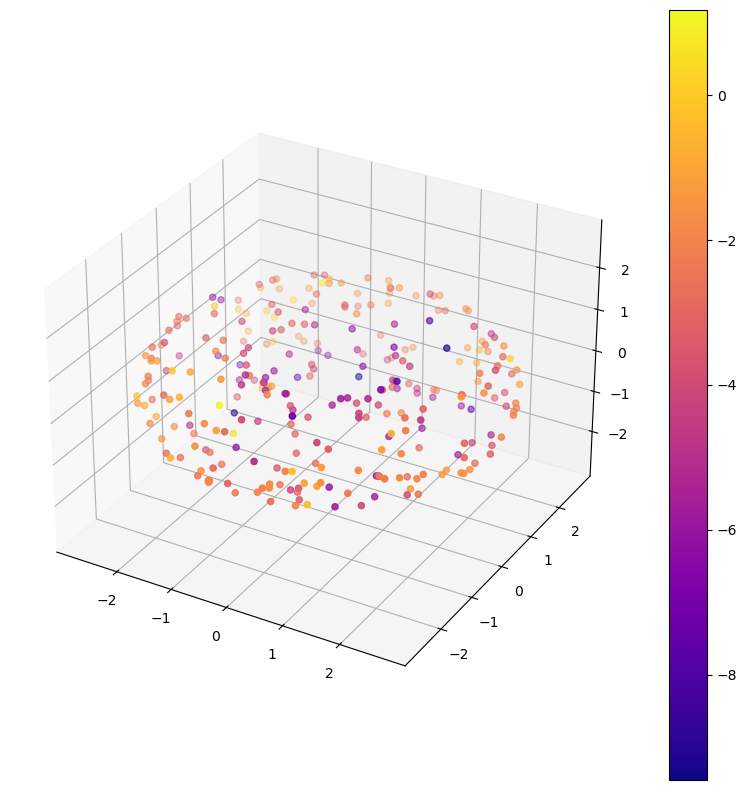

In [ ]:
from diffusion_curvature.utils import plot_3d
plot_3d(X,scalar_ks,colorbar=True)